In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

### Logistic regression on the titanic dataset
The first thing we are going to do is to read in the dataset using the Pandas' read_csv() function. We will put this data into a Pandas DataFrame, called "titanic", and name each of the columns.

In [114]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [115]:
titanic.shape

(891, 12)

The titanic dataframe has 891 observations(rows) and 12 attributes(columns)

### Check if your target variable is binary
Since we are building a model to predict survival of passengers from the Titanic, our target is going to be "Survived" variable from the titanic dataframe. To make sure that it's a binary variable, let's use Seaborn's countplot() function.

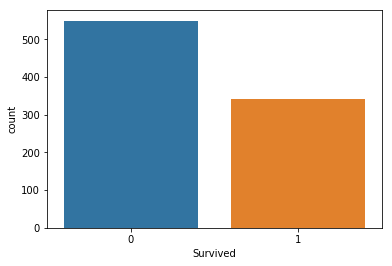

In [116]:
sns.countplot(x="Survived",data=titanic)
plt.show()

### Checking for missing values
It's easy to check for missing values by calling the isnull() method, and the sum() method off of that, to return a tally of all the True values that are returned by the isnull() method.

In [117]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Missing Value Treatment?
Ok, so there are only 891 rows in the titanic data frame. Cabin is almost all missing values, so we can drop that variable completely, but what about age? Age seems like a relevant predictor for survival right? We'd want to keep the variables, but it has 177 missing values.We are going to need to find a way to approximate for those missing values! 
For understanding the working of logistic regression, we will go ahead and replace it with mean for now. 

### Drop variables that are insignificant predictors
So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:

    Survived - This variable is obviously relevant.
    Pclass - Does a passenger's class on the boat affect their survivability?
    Sex - Could a passenger's gender impact their survival rate?
    Age - Does a person's age impact their survival rate?
    SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a       person survivability? Probability
    Parch - Does the number of relatives on the boat (that are children or parents) affect a       person survivability? Probability
    Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
    Embarked - Does a person's point of embarkation matter? It depends on how the boat was         filled... Let's keep it.
What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.

In [118]:
titanic['Age'].fillna((titanic['Age'].mean()), inplace=True)
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [120]:
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Since the variable embarked has just 2 rows with missing values, we will remove these rows rather than changing information.

In [121]:
titanic_data.dropna(inplace=True)

### Converting categorical variables to a dummy indicators
The next thing we need to do is reformat our variables so that they work with the model. Specifically, we need to reformat the Sex and Embarked variables into numeric variables.

In [122]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [123]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [124]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [125]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Now we have a dataset with all the variables in the correct format!

### Checking for independence between features

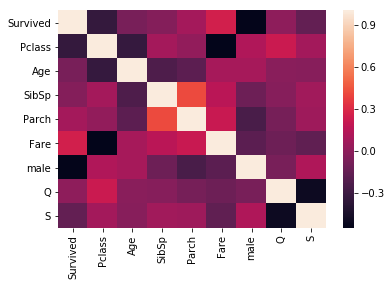

In [126]:
sns.heatmap(titanic_dmy.corr())
plt.show()

We see that fare and Pclass are highly correlated. We keep only one of these variables and since Pclass as a higher correlation with the target, we will keep that and drop the variable fare

In [127]:
titanic_dmy.drop(['Fare'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,1,0,1
1,1,1,38.0,1,0,0,0,0
2,1,3,26.0,0,0,0,0,1
3,1,1,35.0,1,0,0,0,1
4,0,3,35.0,0,0,1,0,1


In [128]:
x = titanic_dmy.ix[:,(1,2,3,4,5,6,7)].values
y = titanic_dmy.ix[:,0].values

C:\Users\ppital499\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [129]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state=25)

### Deploying and evaluating the model

In [130]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [131]:
y_pred = LogReg.predict(X_test)
probs = LogReg.predict_proba(X_test)

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[135,  29],
       [ 34,  69]], dtype=int64)

The results from the confusion matrix are telling us that 135 and 69 are the number of correct predictions. 34 and 29 are the number of incorrect predictions.

In [134]:
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred)

0.76404494382


In [135]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.82      0.81       164
          1       0.70      0.67      0.69       103

avg / total       0.76      0.76      0.76       267



In [136]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

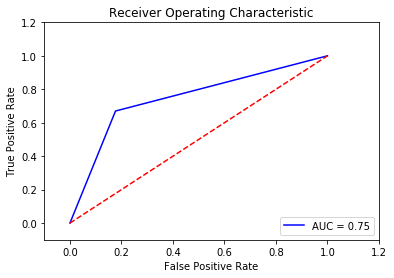

In [137]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

You have successfully implemented Logistic Regression!!